# Bloco 1: Importação das bibliotecas

- Este bloco importa as bibliotecas padrão do ecossistema PyData: numpy para operações numéricas vetoriais e pandas para manipulação de DataFrames.

- Para visualização, importa matplotlib.pyplot e seaborn.

- Do scikit-learn (sklearn), ele importa um conjunto abrangente de módulos para o pipeline de modelagem:

  - **Pré-processamento:** StandardScaler (para normalizar os dados, Z-score) e PCA (Análise de Componentes Principais para redução de dimensionalidade).

  - **Validação do Modelo:** KFold, StratifiedShuffleSplit (estratégias de validação cruzada) e cross_val_predict (para gerar predições de CV).

  - **Seleção de Modelo:** GridSearchCV (para tunelagem exaustiva de hiperparâmetros).

  - **Modelo (Estimador):** SVC (Support Vector Classifier).

  - **Workflow:** Pipeline (para encadear transformações e o estimador).

  - **Métricas:** ConfusionMatrixDisplay, classification_report, accuracy_score (para avaliação de desempenho).

  - **Interpretação:** permutation_importance (para avaliação de importância das features).

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedShuffleSplit, GridSearchCV, cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance

# Configuração inicial para garantir que os resultados sejam reprodutíveis
RANDOM_STATE = 42
sns.set_theme(style="whitegrid")

# Bloco 2: Carregar o dataset

- Utiliza pandas.read_csv para carregar os dados de um CSV remoto (Heart desease (Cleaveland)).

- Realiza a separação entre a matriz de features (X), contendo as variáveis independentes (preditores), e o vetor alvo (y), contendo a variável dependente (classes), através do método .drop() e indexação de DataFrame.

In [28]:
url_dataset = 'https://raw.githubusercontent.com/lea-machado/Machine_Learning_SUMMIT_UMC_2025/main/Heart_disease_cleveland_new.csv'

df_heart = pd.read_csv(url_dataset)

print("\nDimensão do dataset (linhas, colunas):", df_heart.shape)
print("\nPrimeiras 5 linhas do dataset:")
print(df_heart.head())

print(f"\nDimensão do dataset: {df_heart.shape}")
X = df_heart.drop("target", axis=1)
y = df_heart["target"]


Dimensão do dataset (linhas, colunas): (303, 14)

Primeiras 5 linhas do dataset:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   0       145   233    1        2      150      0      2.3      2   
1   67    1   3       160   286    0        2      108      1      1.5      1   
2   67    1   3       120   229    0        2      129      1      2.6      1   
3   37    1   2       130   250    0        0      187      0      3.5      2   
4   41    0   1       130   204    0        2      172      0      1.4      0   

   ca  thal  target  
0   0     2       0  
1   3     1       1  
2   2     3       1  
3   0     1       0  
4   0     1       0  

Dimensão do dataset: (303, 14)


# Bloco 3: Tratamento de dados

- Define a arquitetura do modelo usando Pipeline do sklearn.

- Esta pipeline define duas etapas sequenciais:

  1. **"scaler":** Uma instância do StandardScaler para aplicar a padronização (Z-score) aos dados de entrada X.

  2. **"svc":** Uma instância do SVC (Support Vector Classifier) com um random_state fixo para garantir a reprodutibilidade.

In [29]:
X = df_heart.drop("target", axis=1)
y = df_heart["target"]

print(f"\nDimensões das Features (X): {X.shape}")
print(f"Dimensões da Variável Alvo (y): {y.shape}")

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=RANDOM_STATE))
])


Dimensões das Features (X): (303, 13)
Dimensões da Variável Alvo (y): (303,)


# Bloco 4: Separação do modelo em treino e teste

- Este bloco não executa uma divisão train_test_split tradicional. Em vez disso, ele instancia dois geradores de split de validação cruzada (CV) que serão passados para o GridSearchCV:

  - **KFold:** CV padrão com 10 folds (n_splits=10), com embaralhamento (shuffle=True) e random_state fixo.

  - **StratifiedShuffleSplit (SSS):** CV que preserva a distribuição das classes (estratificação). Define 10 iterações (n_splits=10) com uma divisão de 25% para o conjunto de teste (test_size=0.25)

In [30]:
# KFold com 10 divisões, embaralhando os dados
kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# StratifiedShuffleSplit com 10 divisões, 25% para teste, preservando proporção das classes
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=RANDOM_STATE)

print("\nEstratégias de Validação Cruzada definidas:")
print(f" - KFold: {kfold}")
print(f" - StratifiedShuffleSplit: {sss}")


Estratégias de Validação Cruzada definidas:
 - KFold: KFold(n_splits=10, random_state=42, shuffle=True)
 - StratifiedShuffleSplit: StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.25,
            train_size=None)


# Bloco 5: Definição do modelo

- Define a grade de hiperparâmetros (param_grid) para a busca do GridSearchCV.

- A grade é uma lista de dicionários, permitindo testar diferentes kernels:

  - **Kernel Linear:** Testa 5 valores para o hiperparâmetro de regularização C (svc__C).

  - **Kernel RBF (Radial Basis Function):** Testa uma combinação de 5 valores de C (svc__C) e 3 valores para gamma (svc__gamma: 'scale', 0.01, 0.001).

- A sintaxe svc__ é usada para especificar que o hiperparâmetro (ex: C) pertence à etapa "svc" da Pipeline.

In [31]:
# Define a grade de hiperparâmetros a serem testados pelo GridSearchCV
# Inclui testes para kernel linear e RBF com diferentes valores de C e gamma
param_grid = [
    {'svc__kernel': ['linear'], 'svc__C': [0.01, 0.1, 1, 10, 100]},
    {'svc__kernel': ['rbf'], 'svc__C': [0.01, 0.1, 1, 10, 100], 'svc__gamma': ['scale', 0.01, 0.001]}
]

print("\nPipeline do modelo definido:")
print(pipe)
print("\nGrade de Hiperparâmetros definida:")
print(param_grid)


Pipeline do modelo definido:
Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(random_state=42))])

Grade de Hiperparâmetros definida:
[{'svc__kernel': ['linear'], 'svc__C': [0.01, 0.1, 1, 10, 100]}, {'svc__kernel': ['rbf'], 'svc__C': [0.01, 0.1, 1, 10, 100], 'svc__gamma': ['scale', 0.01, 0.001]}]


# Bloco 6: Treinar modelo

- Este bloco executa a otimização de hiperparâmetros.

- Duas instâncias de GridSearchCV são criadas: grid_kfold e grid_sss.

- Ambas recebem a mesma Pipeline (Bloco 3) e a mesma param_grid (Bloco 5).

- Elas diferem no parâmetro cv: uma usa o gerador kfold e a outra o sss.

- scoring="accuracy" define a métrica de otimização e n_jobs=-1 utiliza todos os cores de CPU disponíveis.

- O método .fit(X, y) inicia o processo: o GridSearchCV gerencia internamente as divisões de CV, treina o modelo em cada fold com cada combinação de parâmetros e armazena os resultados.

In [32]:
# Treinamento com GridSearchCV usando KFold
print("\nIniciando GridSearchCV com KFold-10... (Isso pode levar alguns segundos)")
grid_kfold = GridSearchCV(pipe, param_grid, cv=kfold, scoring="accuracy", n_jobs=-1)
grid_kfold.fit(X, y)
print("GridSearchCV com KFold-10 concluído.")

# Treinamento com GridSearchCV usando StratifiedShuffleSplit
print("\nIniciando GridSearchCV com StratifiedShuffleSplit...")
grid_sss = GridSearchCV(pipe, param_grid, cv=sss, scoring="accuracy", n_jobs=-1)
grid_sss.fit(X, y)
print("GridSearchCV com StratifiedShuffleSplit concluído.")


Iniciando GridSearchCV com KFold-10... (Isso pode levar alguns segundos)
GridSearchCV com KFold-10 concluído.

Iniciando GridSearchCV com StratifiedShuffleSplit...
GridSearchCV com StratifiedShuffleSplit concluído.


# Bloco 7: Avaliação do modelo

- Esta seção extrai e visualiza os dados armazenados nos objetos grid_kfold.cv_results_ e grid_sss.cv_results_

## Definição das funções de visualização

In [33]:
def gerar_graficos_comparativos(results_df):
    print("\nGerando gráficos de linha comparativos...")
    linear_results = results_df[results_df['param_svc__kernel'] == 'linear']
    rbf_results = results_df[results_df['param_svc__kernel'] == 'rbf']

    # Define a paleta de cores personalizada
    cores_personalizadas = {
        'KFold': 'purple',
        'StratifiedShuffleSplit': 'red'
    }

    # Gráfico para kernel linear
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=linear_results, x='param_svc__C', y='mean_test_score', hue='cv_strategy',
                 marker='o', linestyle='--', palette=cores_personalizadas)
    plt.xscale('log')
    plt.title("Comparação de Acurácia Média - Kernel Linear", fontsize=16)
    plt.xlabel("Parâmetro C", fontsize=12)
    plt.ylabel("Acurácia Média", fontsize=12)
    plt.legend(title="Estratégia de CV")
    plt.show()

    # Gráfico para kernel RBF
    rbf_results_plot = rbf_results.copy()
    rbf_results_plot['param_svc__gamma'] = rbf_results_plot['param_svc__gamma'].astype(str)

    g = sns.FacetGrid(rbf_results_plot, col="param_svc__gamma", hue="cv_strategy",
                      height=5, palette=cores_personalizadas, col_wrap=3)
    g.map(sns.lineplot, "param_svc__C", "mean_test_score", marker="o", linestyle='--')
    g.set_axis_labels("Parâmetro C", "Acurácia Média")
    g.set_titles("Gamma = {col_name}")
    g.add_legend(title="Estratégia de CV")
    g.set(xscale="log")
    plt.suptitle("Comparação de Acurácia Média - Kernel RBF", y=1.03, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def plot_cv_indices(cv, X, y, ax, n_splits, title):
    """Função auxiliar para desenhar os gráficos de divisão dos dados."""
    for i, (train, test) in enumerate(cv.split(X=X, y=y)):
        indices = np.array([np.nan] * len(X))
        indices[test] = 1
        indices[train] = 0
        ax.scatter(range(len(indices)), [i + .5] * len(indices), c=indices, marker='_', lw=lw, cmap=plt.cm.viridis, vmin=-.2, vmax=1.2)
    ax.set_yticks(np.arange(n_splits) + .5)
    ax.set_yticklabels([f'Iteração {i+1}' for i in range(n_splits)])
    ax.set_xlabel('Índice da Amostra de Dado')
    ax.set_ylabel(None)
    ax.set_ylim([n_splits, -.5])
    ax.set_xlim([0, len(X)])
    ax.set_title(title, fontsize=14)
    ax.legend([plt.Line2D([0], [0], color=plt.cm.viridis(0.8), lw=lw),
               plt.Line2D([0], [0], color=plt.cm.viridis(0.1), lw=lw)],
              ['Teste', 'Treino'], loc=(1.02, 0.8))

## Tabela resumo

- Acessa os atributos .best_score_, .best_params_ e .cv_results_['std_test_score'][grid_kfold.best_index_] de cada objeto GridSearchCV para comparar o desempenho ótimo das duas estratégias.

In [34]:

print("Resumo comparativo dos resultados:")
summary_data = {
    "Estratégia CV": ["KFold-10", "StratifiedShuffleSplit"],
    "Melhor Acurácia Média": [grid_kfold.best_score_, grid_sss.best_score_],
    "Desvio Padrão (Melhor)": [
        grid_kfold.cv_results_['std_test_score'][grid_kfold.best_index_],
        grid_sss.cv_results_['std_test_score'][grid_sss.best_index_]
    ],
    "Melhores Parâmetros": [grid_kfold.best_params_, grid_sss.best_params_]
}
df_summary = pd.DataFrame(summary_data)
try:
    display(df_summary)
except NameError:
    print(df_summary)

Resumo comparativo dos resultados:


,Estratégia CV,Melhor Acurácia Média,Desvio Padrão (Melhor),Melhores Parâmetros
0,KFold-10,0.841290,0.050953,"{'svc__C': 10, 'svc__gamma': 0.001, 'svc__kern..."
1,StratifiedShuffleSplit,0.844737,0.022638,"{'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__k..."


## Gráficos de linha comparativos

- Concatena os cv_results_ de ambos os grids em um único DataFrame pandas e usa seaborn.lineplot e seaborn.FacetGrid para plotar a acurácia média em função dos hiperparâmetros, comparando os dois métodos.


Gerando gráficos de linha comparativos...


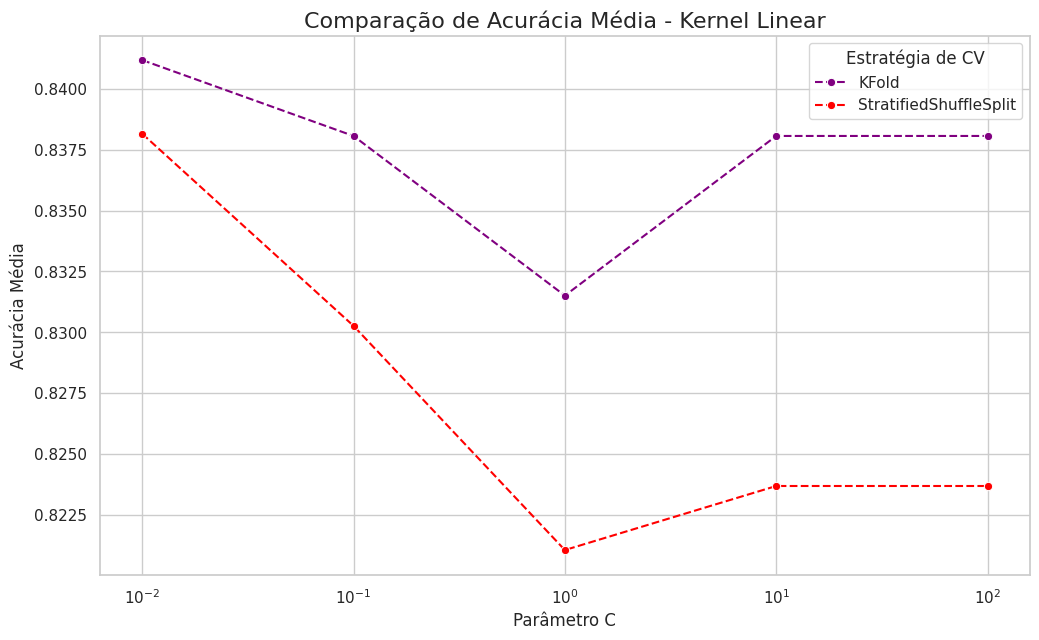

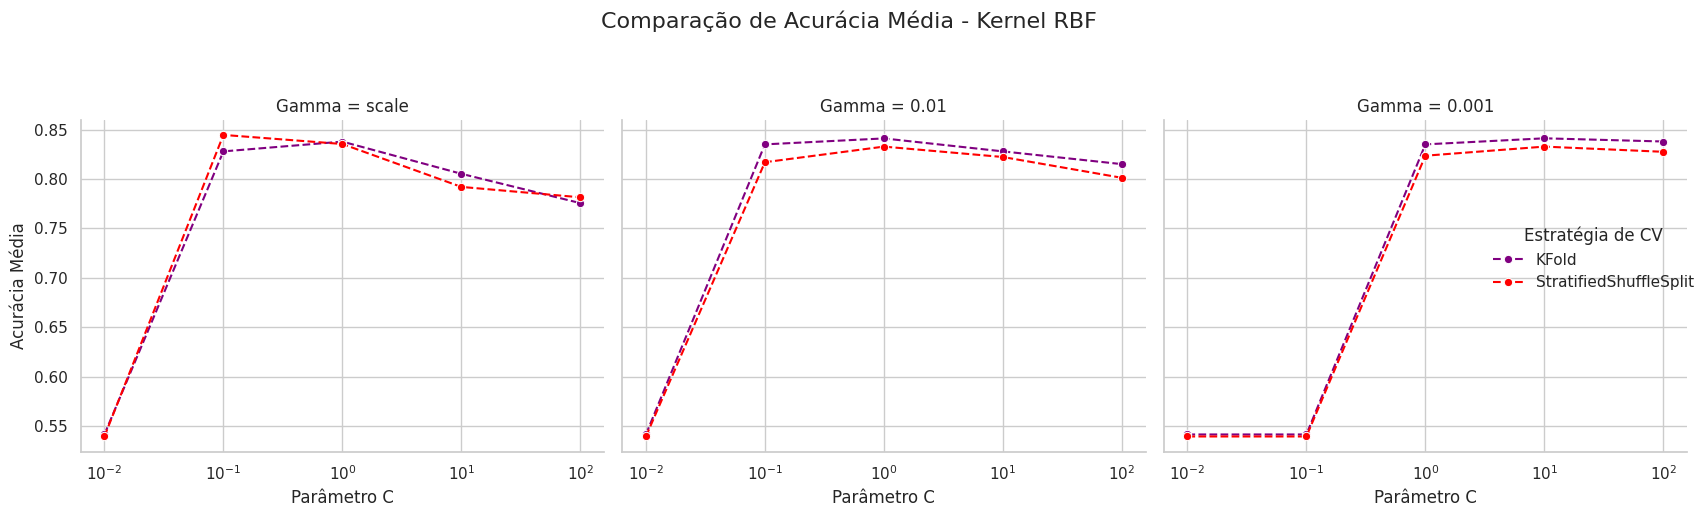

In [35]:
results_kfold_df = pd.DataFrame(grid_kfold.cv_results_)
results_sss_df = pd.DataFrame(grid_sss.cv_results_)
results_kfold_df['cv_strategy'] = 'KFold'
results_sss_df['cv_strategy'] = 'StratifiedShuffleSplit'
all_results_df = pd.concat([results_kfold_df, results_sss_df], ignore_index=True)

gerar_graficos_comparativos(all_results_df)

## Matrizes de confusão e relatórios de classificação

- Utiliza cross_val_predict no melhor estimador do KFold (grid_kfold.best_estimator_) para gerar predições out-of-fold para todo o dataset. Para o SSS, como os folds podem se sobrepor, ele simula o cross_val_predict manualmente em um loop, acumulando predições apenas para índices de teste únicos. As matrizes são então plotadas com ConfusionMatrixDisplay.

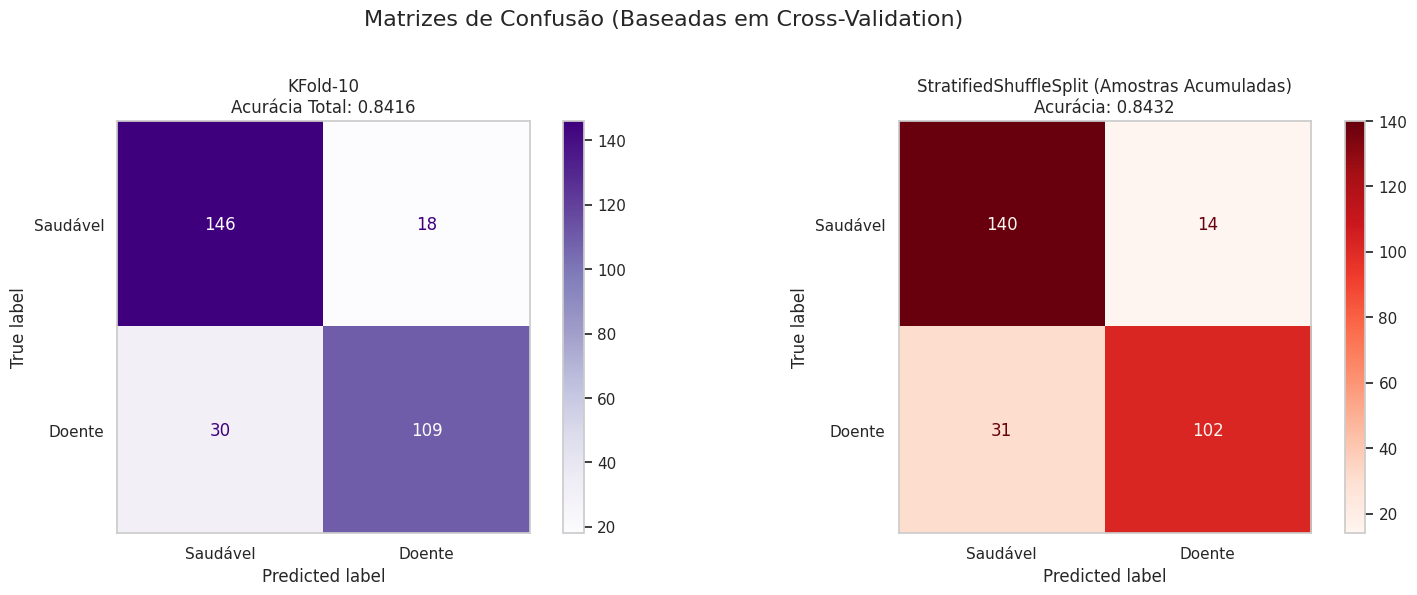


--- RELATÓRIO DE CLASSIFICAÇÃO (KFold-10) ---

              precision    recall  f1-score   support

    Saudável       0.83      0.89      0.86       164
      Doente       0.86      0.78      0.82       139

    accuracy                           0.84       303
   macro avg       0.84      0.84      0.84       303
weighted avg       0.84      0.84      0.84       303


--- RELATÓRIO DE CLASSIFICAÇÃO (StratifiedShuffleSplit - Amostras Acumuladas) ---

              precision    recall  f1-score   support

    Saudável       0.82      0.91      0.86       154
      Doente       0.88      0.77      0.82       133

    accuracy                           0.84       287
   macro avg       0.85      0.84      0.84       287
weighted avg       0.85      0.84      0.84       287



In [36]:
# Obter predições usando cross_val_predict para cada estratégia com seu melhor estimador
y_pred_kfold = cross_val_predict(grid_kfold.best_estimator_, X, y, cv=kfold)

# Para StratifiedShuffleSplit, cross_val_predict não funciona diretamente como no KFold, porque os índices de teste podem se sobrepor. Usaremos um loop manual para acumular predições.
best_model_sss = grid_sss.best_estimator_
y_true_acumulado_sss = []
y_pred_acumulado_sss = []
indices_acumulados_sss = []

# Loop através das divisões criadas pelo SSS
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Treinar o melhor modelo no conjunto de treino da iteração
    best_model_sss.fit(X_train, y_train)

    # Fazer predições no conjunto de teste da iteração
    y_pred_iter = best_model_sss.predict(X_test)

    # Guardar os resultados apenas para índices ainda não previstos (para visualização da matriz)
    for i, idx in enumerate(test_idx):
        if idx not in indices_acumulados_sss:
            y_true_acumulado_sss.append(y_test.iloc[i])
            y_pred_acumulado_sss.append(y_pred_iter[i])
            indices_acumulados_sss.append(idx)


# Plotar as Matrizes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Matrizes de Confusão (Baseadas em Cross-Validation)', fontsize=16)

# Matriz para KFold
ConfusionMatrixDisplay.from_predictions(y, y_pred_kfold, ax=axes[0], cmap='Purples', display_labels=['Saudável', 'Doente'])
axes[0].set_title(f'KFold-10\nAcurácia Total: {accuracy_score(y, y_pred_kfold):.4f}')
axes[0].grid(False)

# Matriz para StratifiedShuffleSplit (com dados acumulados)
if y_true_acumulado_sss:
    ConfusionMatrixDisplay.from_predictions(y_true_acumulado_sss, y_pred_acumulado_sss, ax=axes[1], cmap='Reds', display_labels=['Saudável', 'Doente'])
    axes[1].set_title(f'StratifiedShuffleSplit (Amostras Acumuladas)\nAcurácia: {accuracy_score(y_true_acumulado_sss, y_pred_acumulado_sss):.4f}')
else:
    axes[1].set_title('StratifiedShuffleSplit (Nenhuma amostra única acumulada)')
axes[1].grid(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Relatórios de Classificação
print("\n--- RELATÓRIO DE CLASSIFICAÇÃO (KFold-10) ---\n")
print(classification_report(y, y_pred_kfold, target_names=['Saudável', 'Doente']))
if y_true_acumulado_sss:
    print("\n--- RELATÓRIO DE CLASSIFICAÇÃO (StratifiedShuffleSplit - Amostras Acumuladas) ---\n")
    print(classification_report(y_true_acumulado_sss, y_pred_acumulado_sss, target_names=['Saudável', 'Doente']))
else:
    print("\n--- RELATÓRIO DE CLASSIFICAÇÃO (StratifiedShuffleSplit) - Não foi possível gerar com amostras únicas acumuladas. ---")

## Análise Visual das Estratégias de Validação Cruzada

- Usa uma função auxiliar (plot_cv_indices) para visualizar como os geradores kfold.split() e sss.split() particionam os índices dos dados em treino (azul) e teste (verde) em cada iteração.

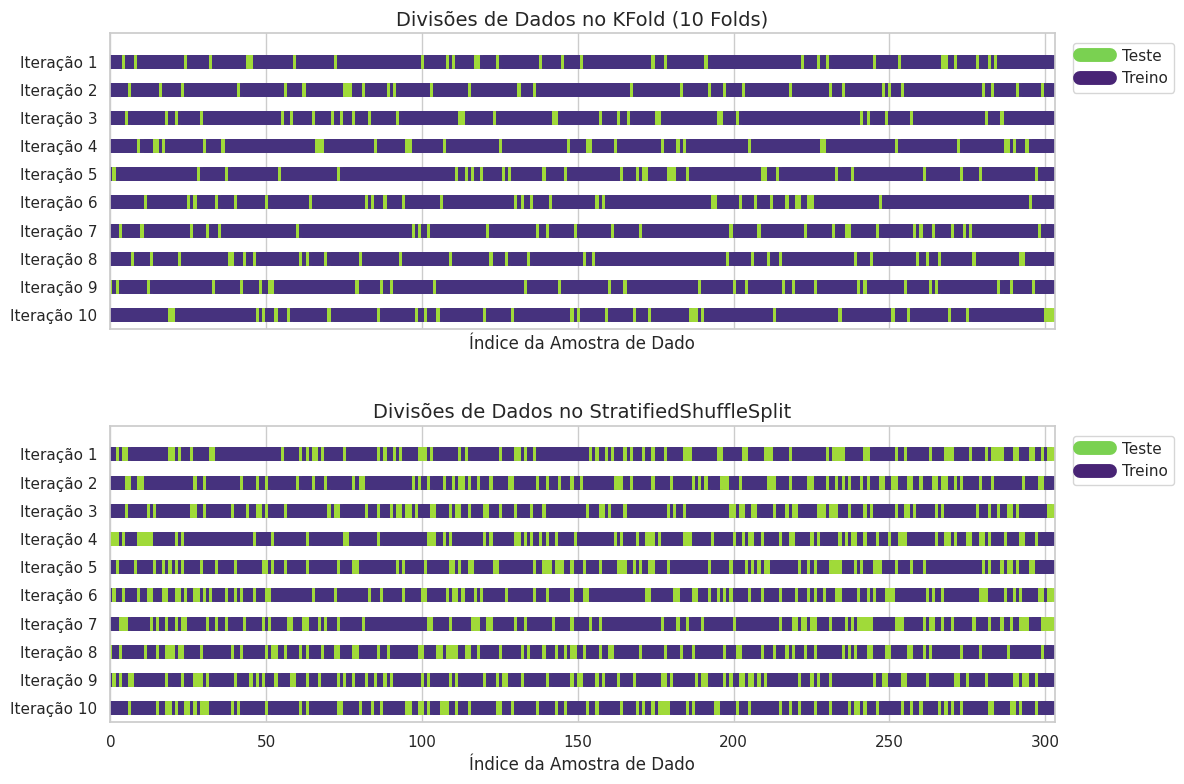

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

lw = 10

plot_cv_indices(kfold, X, y, ax1, 10, 'Divisões de Dados no KFold (10 Folds)')
plot_cv_indices(sss, X, y, ax2, 10, 'Divisões de Dados no StratifiedShuffleSplit')

fig.tight_layout(h_pad=3.0)
plt.show()

## Análise da sensibiliade aos hiperparâmetros com Heatmap (Kernel RBF - StratifiedShuffleSplit)

- Filtra os resultados do grid_sss apenas para o kernel 'rbf' e usa pandas.pivot_table para criar uma matriz 2D (C vs Gamma), que é então plotada com seaborn.heatmap.

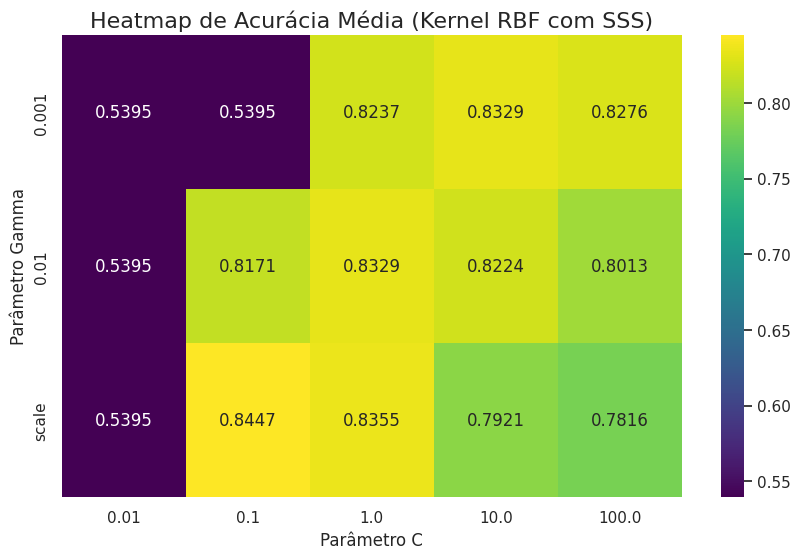

In [38]:
# Usa o dataframe results_sss_df já criado, filtrando apenas RBF
rbf_results_sss_only = results_sss_df[results_sss_df['param_svc__kernel'] == 'rbf'].copy()

# Converte gamma para string para incluir 'scale' como categoria
rbf_results_sss_only['param_svc__gamma'] = rbf_results_sss_only['param_svc__gamma'].astype(str)

# Cria a tabela pivot para o heatmap
pivot = rbf_results_sss_only.pivot_table(
    index='param_svc__gamma',
    columns='param_svc__C',
    values='mean_test_score'
)

# Plota o heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="viridis")
plt.title('Heatmap de Acurácia Média (Kernel RBF com SSS)', fontsize=16)
plt.xlabel('Parâmetro C', fontsize=12)
plt.ylabel('Parâmetro Gamma', fontsize=12)
plt.show()


## Visualização da separação de classes com PCA

- Aplica o StandardScaler (extraído do pipeline do KFold) a todo o X. Em seguida, usa PCA(n_components=2) para reduzir a dimensionalidade dos dados escalados de 13 para 2 componentes. O resultado é plotado com seaborn.scatterplot, comparando as classes reais (style) com as classes preditas (y).

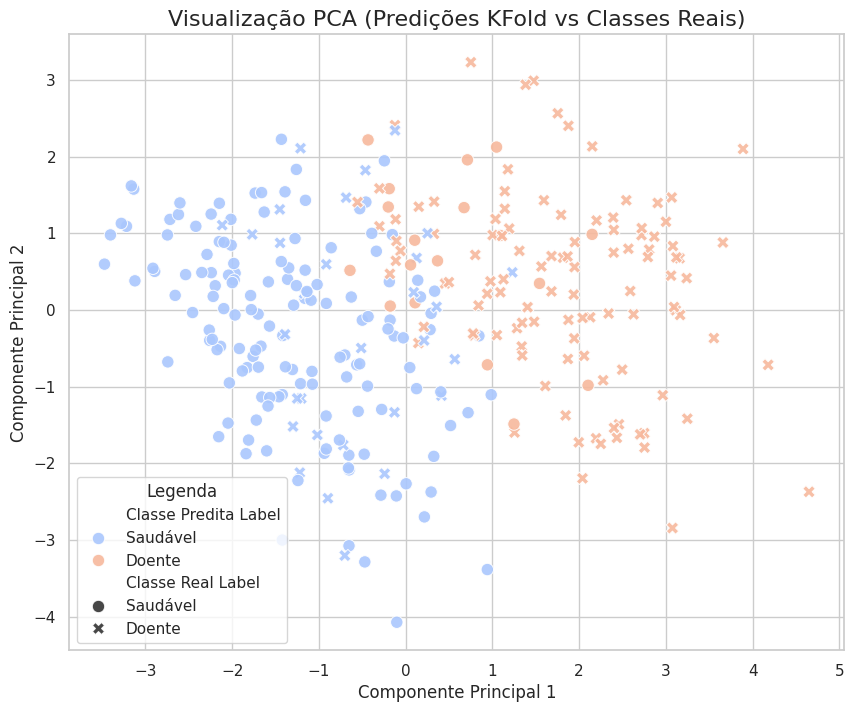

In [40]:
# Usaremos as predições do KFold (y_pred_kfold) que cobrem todo o dataset
# Precisamos escalar TODOS os dados (X) usando o scaler do melhor pipeline KFold
scaler_kfold = grid_kfold.best_estimator_.named_steps['scaler']
X_scaled = scaler_kfold.transform(X)

# Aplica o PCA nos dados completos já escalados
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Cria um DataFrame para facilitar a plotagem com Seaborn
df_pca = pd.DataFrame(data=X_pca, columns=['Componente Principal 1', 'Componente Principal 2'])
df_pca['Classe Real'] = y # Adiciona a classe real
df_pca['Classe Predita (KFold)'] = y_pred_kfold

# Mapeia os valores numéricos das classes para nomes (opcional, para legenda)
label_map = {0: 'Saudável', 1: 'Doente'}
df_pca['Classe Real Label'] = df_pca['Classe Real'].map(label_map)
df_pca['Classe Predita Label'] = df_pca['Classe Predita (KFold)'].map(label_map)

# Plota o resultado
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="Componente Principal 1", y="Componente Principal 2",
    hue="Classe Predita Label",
    style="Classe Real Label",
    palette='coolwarm',
    data=df_pca,
    alpha=0.9, s=80,
    markers=['o', 'X']
)
plt.title("Visualização PCA (Predições KFold vs Classes Reais)", fontsize=16)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Legenda")
plt.show()

## Análise da Importância das Features

- Verifica o melhor kernel (best_kernel). Se for 'linear', plota a magnitude dos coeficientes (svm_model.coef_). Como é 'rbf', ele recorre ao permutation_importance (uma técnica model-agnostic) para avaliar a importância de cada feature medindo o quanto a acurácia cai quando a feature é embaralhada.


Análise da Importância das Features
O melhor modelo (KFold) usa kernel: 'rbf'
Calculando importância por permutação (kernel RBF)... (Isso pode levar alguns segundos)

Features mais importantes encontradas:
    Feature  Importance
11       ca    0.054455
12     thal    0.050825
2        cp    0.036634
8     exang    0.009571
7   thalach    0.006931


/tmp/ipython-input-3321279840.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


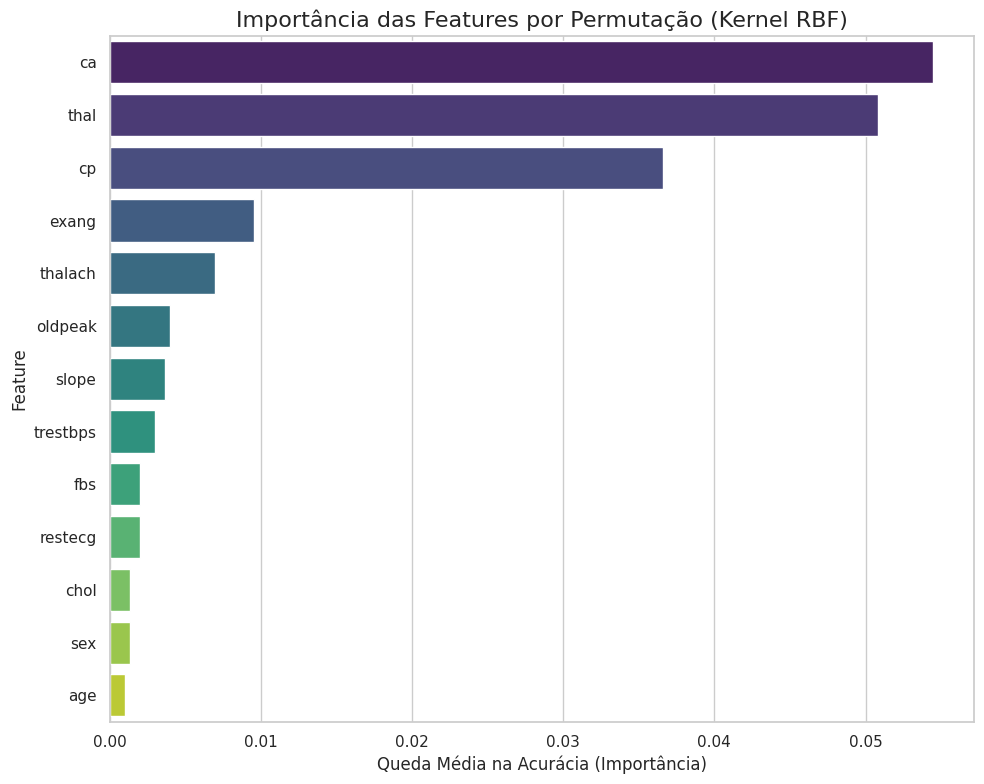

In [42]:
print("\nAnálise da Importância das Features")

# 1. Identificar o melhor estimador (pipeline) e o kernel
best_model_pipeline = grid_kfold.best_estimator_
best_params = grid_kfold.best_params_
best_kernel = best_params.get('svc__kernel', 'rbf') # Extrai o nome do kernel

# 2. Obter nomes das features (a variável 'X' deve estar disponível do Bloco 3)
feature_names = X.columns

print(f"O melhor modelo (KFold) usa kernel: '{best_kernel}'")

# 3. Calcular a importância baseado no tipo de kernel
if best_kernel == 'linear':
    print("Calculando importância a partir dos coeficientes (kernel linear)...")

    # 3a. Obter o modelo SVM de dentro do pipeline
    svm_model = best_model_pipeline.named_steps['svc']

    # Obter os coeficientes. Usamos np.abs() pois a magnitude é o que importa.
    importances = np.abs(svm_model.coef_[0])

    df_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    plot_title = "Importância das Features (Coeficientes SVM Linear)"
    plot_xlabel = "Magnitude do Coeficiente (Absoluto)"

else:
    print(f"Calculando importância por permutação (kernel {best_kernel.upper()})... (Isso pode levar alguns segundos)")

    # 3b. Usar Permutation Importance no dataset completo
    # (Alinhado com a abordagem de CV do notebook)
    perm_importance = permutation_importance(
        best_model_pipeline,
        X,
        y,
        n_repeats=10,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        scoring='accuracy'
    )

    importances = perm_importance.importances_mean

    df_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    plot_title = f"Importância das Features por Permutação (Kernel {best_kernel.upper()})"
    plot_xlabel = "Queda Média na Acurácia (Importância)"

# 4. Ordenar o DataFrame pela importância
df_importance_sorted = df_importance.sort_values(by='Importance', ascending=False)

print("\nFeatures mais importantes encontradas:")
print(df_importance_sorted.head())

# 5. Plotar o gráfico de barras horizontal
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=df_importance_sorted,
    palette='viridis'
)
plt.title(plot_title, fontsize=16)
plt.xlabel(plot_xlabel, fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

# Bloco 8: Conclusão

O objetivo deste notebook foi treinar e avaliar um modelo de Support Vector Classifier (SVC) para a classificação de pacientes com e sem doença cardíaca. A principal análise comparou duas estratégias de validação cruzada (CV) para a otimização de hiperparâmetros: KFold (10 dobras) e StratifiedShuffleSplit (SSS).

Em resumo, o StratifiedShuffleSplit é a metodologia superior para este problema, pois produziu um modelo não linear (SVC com RBF) com a maior acurácia média e, crucialmente, a maior estabilidade (menor variância) durante os testes. Além disso, como as amostras de teste e treino são estratificadas, torna-se um fator de relevância para a escolha, visto que dados biomédicos são, em sua maioria, desbalanceados.

## **Melhor Opção de Estratégia: StratifiedShuffleSplit (SSS)**

Com base na tabela resumo, o SSS provou ser a melhor estratégia de validação visto que:

- **Acurácia Média:** O SSS alcançou uma acurácia média ligeiramente superior (84,47%) em comparação com o KFold (84,13%).

- **Estabilidade do Modelo:** A diferença mais significativa está no desvio padrão. O SSS teve um desvio padrão muito menor (0.0226) do que o KFold (0.0509). Isso indica que o desempenho do modelo SSS foi muito mais consistente e confiável em suas 10 iterações de teste, tornando-o menos dependente da sorte na divisão dos dados.

## **O Porquê da Escolha (Observações dos Gráficos)**

- **Gráfico de Divisão de Dados:** O SSS é estratificado, o que significa que ele garante que a proporção de pacientes "Saudáveis" e "Doentes" seja a mesma em cada conjunto de treino e teste. O gráfico de divisão do SSS mostra como os dados de teste são amostrados aleatoriamente de todo o conjunto de dados, o que leva a uma estimativa de desempenho mais robusta e menos enviesada do que as divisões sequenciais do KFold.

- **Gráficos de Linha:** Ambos os métodos de CV concordaram que o kernel 'rbf' (não linear) superou o kernel 'linear', como visto na tabela de melhores parâmetros.

- **Visualização PCA:** O gráfico de PCA justifica a escolha do kernel RBF. Ele mostra que as classes "Saudável" (círculos) e "Doente" (X) não são linearmente separáveis; elas estão sobrepostas, exigindo o limite de decisão não linear que o RBF oferece.

- **Heatmap (RBF - SSS):** Este gráfico ilustra a sensibilidade do kernel RBF. A melhor acurácia (0.845) foi encontrada em uma combinação específica (C=0.1, gamma='scale'), mostrando a importância da tunelagem.

## **Desempenho do Modelo e Features Relevantes**

- **Matrizes de Confusão:** Ambos os modelos finais (KFold e SSS) alcançaram uma acurácia geral semelhante de 84% nas predições cruzadas. O modelo SSS teve uma leve vantagem em identificar corretamente pacientes "Saudáveis" (recall de 0.91 vs 0.89 do KFold).

- **Importância das Features:** A análise de permutação mostrou que o modelo RBF (o melhor encontrado) baseou suas decisões principalmente em três características: ca (nº de vasos principais), thal (tipo de defeito) e cp (tipo de dor no peito). Isso sugere que estas são as variáveis clínicas mais preditivas no conjunto de dados.